# AML Final Project

#### Import libraries and some utility functions

In [ ]:
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.densenet import preprocess_input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import regularizers
from shutil import copyfile
import os
from scipy.io import loadmat
import json
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from sklearn import preprocessing
from sklearn.svm import LinearSVC
import tqdm


#Utility function for moving images to labeled-folders (train, valid, test)
def move_files(dir_name, labels):
    cur_dir_path = os.path.join(data_path, dir_name)
    if not os.path.exists(cur_dir_path):
        os.mkdir(cur_dir_path)

    for i in range(0, 102):
        class_dir = os.path.join(data_path, dir_name, str(i))
        os.mkdir(class_dir)

    for label in labels:
        src = str(label[0])
        dst = os.path.join(data_path, dir_name, label[1], src.split(os.sep)[-1])
        copyfile(src, dst)

# Plot the acc/loss trends
def plot_history(history, x_plot):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, history.history['loss'])
    plt.plot(x_plot, history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, history.history['accuracy'])
    plt.plot(x_plot, history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

# Plot a confusion matrix
def plot_cm(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('True Negatives: ', cm[0][0])
    print('False Positives: ', cm[0][1])
    print('False Negatives: ', cm[1][0])
    print('True Positives: ', cm[1][1])
    plt.show()

# Extract features from the CNN
def extract_features(directory, cnn, feature_size, sample_size=100, batch_size=16):
    datagen = ImageDataGenerator(rescale=1. / 255, preprocessing_function=preprocess_input)
    features = np.zeros(shape=(sample_size, feature_size))
    labels = np.zeros(shape=(sample_size, 102))
    generator = datagen.flow_from_directory(directory=os.path.join(data_path, directory), target_size=(224, 224),
                                            batch_size=batch_size, color_mode='rgb', class_mode='categorical')
    i = 0
    for imgs, lbls in tqdm.tqdm(generator):
        features[i * batch_size:(i + 1) * batch_size, ] = cnn.predict(imgs)
        labels[i * batch_size:(i + 1) * batch_size, ] = lbls
        i = i + 1
        if (i + 1) * batch_size > sample_size: break
    return features, labels

# Load dataset from Drive

The dataset was downloaded from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/ and uploaded on Google Drive.

In [ ]:
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/MyDrive/"
data_path = root_dir + "Colab Notebooks/Flowers/flowers/"

Mounted at /content/gdrive


# Data Exploration

Here we are building the train/val/test splits reading the informations contained in the downloaded files.
Moreover we take a look on the dataset distribution: 1020 images in training set (10 image per class), same for validation and the remaining 6149 in the test set.
The training set is balanced so we do not need further processing.

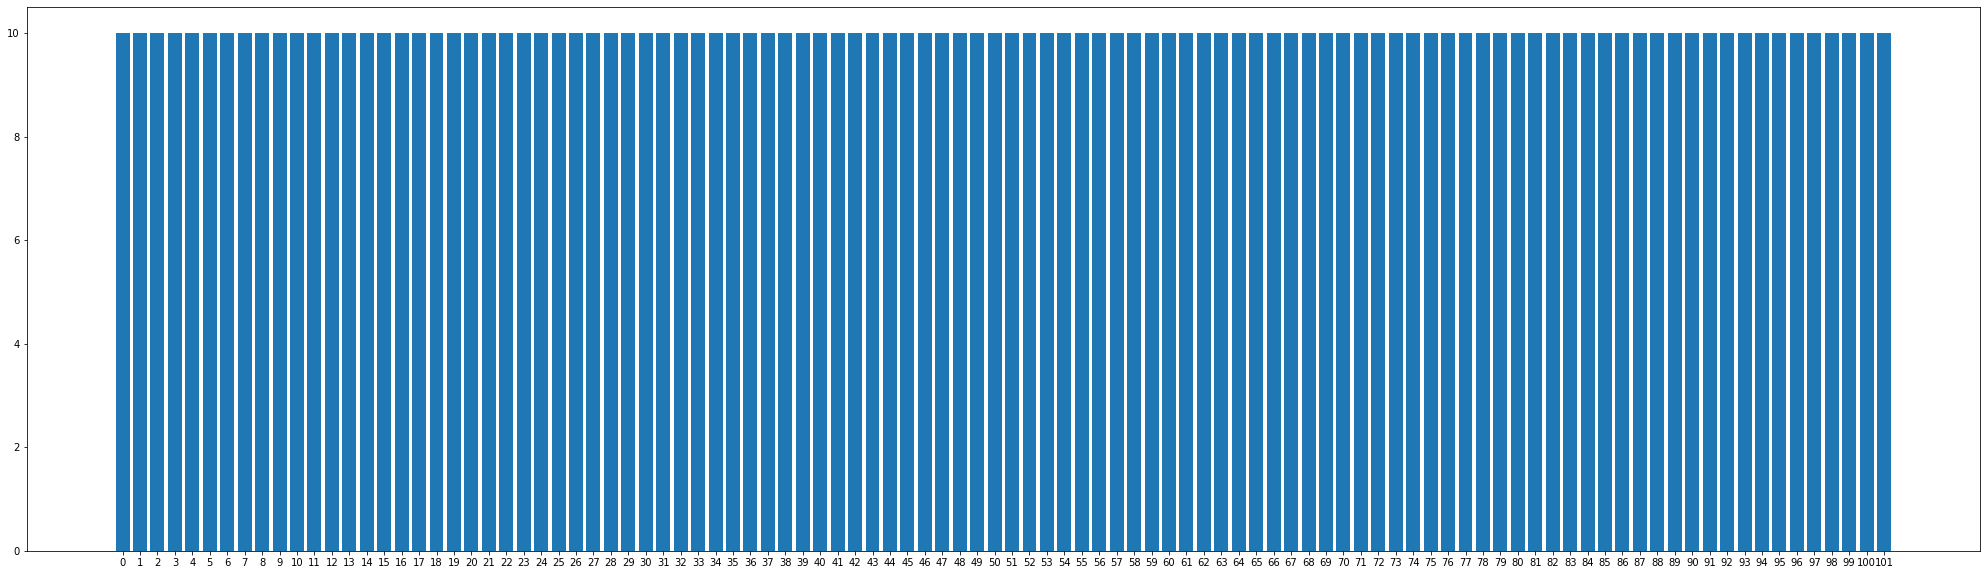

Training labels distribution: [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10), (20, 10), (21, 10), (22, 10), (23, 10), (24, 10), (25, 10), (26, 10), (27, 10), (28, 10), (29, 10), (30, 10), (31, 10), (32, 10), (33, 10), (34, 10), (35, 10), (36, 10), (37, 10), (38, 10), (39, 10), (40, 10), (41, 10), (42, 10), (43, 10), (44, 10), (45, 10), (46, 10), (47, 10), (48, 10), (49, 10), (50, 10), (51, 10), (52, 10), (53, 10), (54, 10), (55, 10), (56, 10), (57, 10), (58, 10), (59, 10), (60, 10), (61, 10), (62, 10), (63, 10), (64, 10), (65, 10), (66, 10), (67, 10), (68, 10), (69, 10), (70, 10), (71, 10), (72, 10), (73, 10), (74, 10), (75, 10), (76, 10), (77, 10), (78, 10), (79, 10), (80, 10), (81, 10), (82, 10), (83, 10), (84, 10), (85, 10), (86, 10), (87, 10), (88, 10), (89, 10), (90, 10), (91, 10), (92, 10), (93, 10), (94, 10), (95, 10), (96, 10), (97, 10),

In [ ]:
image_labels_path = os.path.join(data_path, 'imagelabels.mat')
names_path = os.path.join(data_path, 'label_to_names.json')

# Dataset split
setid = loadmat(os.path.join(data_path,"setid.mat"))
idx_train = setid['trnid'][0] - 1 
idx_test = setid['tstid'][0] - 1
idx_valid = setid['valid'][0] - 1

# Reading labels
image_labels = loadmat(image_labels_path)['labels'][0] - 1

# Reading names of labels
with open(names_path, mode='r') as file:
  image_names = json.load(file)

# Getting all the image files names
files = sorted(glob.glob(os.path.join(data_path, 'jpg', '*.jpg')))
all_labels = np.array([i for i in zip(files, image_labels)])

# Gathering labeled folders together within each split
if 'train' not in os.listdir(data_path):
    move_files('train', all_labels[idx_train, :])
if 'test' not in os.listdir(data_path):
    move_files('test', all_labels[idx_test, :])
if 'valid' not in os.listdir(data_path):
    move_files('valid', all_labels[idx_valid, :])

train_dict = {}
for cat in range(102):
  train_dict[cat] = len(os.listdir(os.path.join(data_path, "train",str(cat))))

val_dict = {}
for cat in range(102):
  val_dict[cat] = len(os.listdir(os.path.join(data_path, "valid",str(cat))))

test_dict = {}
for cat in range(102):
  test_dict[cat] = len(os.listdir(os.path.join(data_path, "test",str(cat))))

# Print distribution for each split
data_distribution_train = sorted(Counter(train_dict).items())
data_distribution_val = sorted(Counter(val_dict).items())
data_distribution_test = sorted(Counter(test_dict).items())

# Plot the histogram about the training classes
x = np.arange(len(data_distribution_train))
plt.figure(figsize=(35,10))
plt.bar(x, height=[val for _, val in data_distribution_train])
plt.xticks(x, range(len(data_distribution_train)))
plt.show()
print('Training labels distribution:', data_distribution_train)
print('Validation labels distribution:', data_distribution_val)
print('Test labels distribution:', data_distribution_test)

## Pre-processing
We need to load data in an appropriate way in order to process batch of images, leveraging the splits created before.
Next, we apply different pre-processing and data augmentation based on the split.

In [ ]:
# Creating splits for dataset & Pre-process
train_dataGen = ImageDataGenerator(rescale=1./255, rotation_range=20, horizontal_flip=True, preprocessing_function=preprocess_input)
train_generator = train_dataGen.flow_from_directory(directory = os.path.join(data_path, "train"), target_size=(224, 224), class_mode="categorical", shuffle=True, classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

validation_dataGen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
validation_generator = validation_dataGen.flow_from_directory(directory = os.path.join(data_path, "valid"), target_size=(224, 224), class_mode="categorical", classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

test_generator = validation_dataGen.flow_from_directory(directory = os.path.join(data_path, "test"), target_size=(224, 224), class_mode="categorical", classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

Found 1020 images belonging to 102 classes.
Found 1020 images belonging to 102 classes.
Found 6149 images belonging to 102 classes.


### Visualize some images and corresponding labels about the dataset

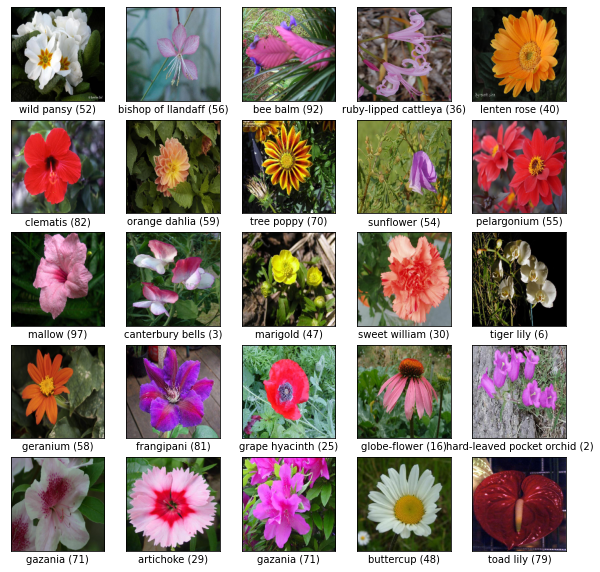

In [ ]:
train_dataGen_sample = ImageDataGenerator(rescale=1./255)
train_generator_sample = train_dataGen_sample.flow_from_directory(directory = os.path.join(data_path, "train"), target_size=(224, 224), class_mode="categorical", shuffle=True, classes=[str(i) for i in range(0, 102)], batch_size=8, seed=42)

# Show some images with labels
plt.figure(figsize=(10,10))
i = 0
for imgs, labels in train_generator_sample:
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(imgs[2,])
    plt.xlabel(f'{image_names[str(np.argmax(labels[2,]))]} ({str(np.argmax(labels[2,]))})')
    i +=1
    if i == 25: break 
plt.show()

# Build a base CNN

Here we are creating a baseline model to train from scratch on the dataset.

In [ ]:
initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1., seed=42)

base_model = keras.Sequential(
    [
     keras.Input(shape=(224, 224, 3)),
     layers.Conv2D(64, kernel_size=(3, 3), activation="relu", strides=(2, 2)),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Conv2D(128, kernel_size=(3, 3), activation="relu", strides=(2, 2)),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Conv2D(256, kernel_size=(3, 3), activation="relu", strides=(2, 2)),
     layers.MaxPooling2D(pool_size=(2, 2)),
     layers.Flatten(),
     layers.Dense(256, activation='relu', kernel_initializer=initializer),
     layers.Dropout(0.3),
     layers.Dense(128, activation='relu', kernel_initializer=initializer),
     layers.Dropout(0.2),
     layers.BatchNormalization(),
     layers.Dense(102, activation="softmax")
    ]
)

base_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 111, 111, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 27, 27, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 6, 256)         295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 3, 256)       

### Train/Evaluate/Test Base CNN

Now we train the base model on the train set. We used an Early stopping criteria to stop the training if necessary and a learning rate scheduler to reduce it when no improvements are made.
We choose the Adam algorithm as optimization with a lr of 0.001 to allow bigger changes on updates.
Because of the one-hot encoded labels (thanks to the flow_from_directory method of ImageDataGenerator class) we use a Categorical Cross-Entropy loss.
Thus, the model was trained for a maximum of 50 epochs.

(We did not set the batch size because the train_generator in an instance of the ImageDataGenerator class thus automatically passing data by batch.)

In [ ]:
EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=0.01, restore_best_weights=True,
                                   verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks = [early_stopping, lr_scheduler]

base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy",
                       metrics=['accuracy'])

history = base_model.fit(train_generator,epochs=EPOCHS, callbacks=callbacks, 
                         validation_data=validation_generator,
                         )

score = base_model.evaluate(validation_generator)
print(f"Val Loss: {score[0]}")
print(f"Val Accuracy: {score[1]}")

Epoch 1/50
128/128 [==============================] - 30s 228ms/step - loss: 4.7726 - accuracy: 0.0225 - val_loss: 5.0347 - val_accuracy: 0.0176 - lr: 0.0010
Epoch 2/50
128/128 [==============================] - 30s 233ms/step - loss: 4.6507 - accuracy: 0.0127 - val_loss: 4.5330 - val_accuracy: 0.0216 - lr: 0.0010
Epoch 3/50
128/128 [==============================] - 28s 223ms/step - loss: 4.5832 - accuracy: 0.0167 - val_loss: 4.4685 - val_accuracy: 0.0186 - lr: 0.0010
Epoch 4/50
128/128 [==============================] - 29s 225ms/step - loss: 4.5476 - accuracy: 0.0147 - val_loss: 4.3748 - val_accuracy: 0.0157 - lr: 0.0010
Epoch 5/50
128/128 [==============================] - 29s 224ms/step - loss: 4.5226 - accuracy: 0.0196 - val_loss: 4.2826 - val_accuracy: 0.0196 - lr: 0.0010
Epoch 6/50
128/128 [==============================] - 29s 224ms/step - loss: 4.4943 - accuracy: 0.0167 - val_loss: 4.3887 - val_accuracy: 0.0206 - lr: 0.0010
Epoch 7/50
128/128 [==============================] 

In [ ]:
print(f"Train accuracy: {np.max(history.history['accuracy'])}")
print(f"Validation accuracy: {np.max(history.history['val_accuracy'])}")
print(f"Train loss: {np.max(history.history['loss'])}")
print(f"Validation loss: {np.max(history.history['val_loss'])}")

Train accuracy: 0.03529411926865578
Validation accuracy: 0.036274511367082596
Train loss: 4.772574424743652
Validation loss: 5.034738540649414


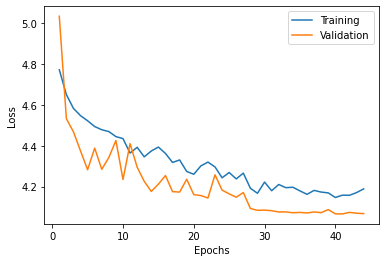

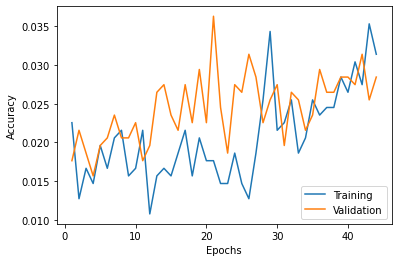

In [ ]:
x_plot = list(range(1, len(history.history['val_accuracy']) + 1))
plot_history(history, x_plot)

In [ ]:
score = base_model.evaluate(test_generator)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

769/769 [==============================] - 2705s 4s/step - loss: 4.1068 - accuracy: 0.0332
Test Loss: 4.106826305389404
Test Accuracy: 0.033176127821207047


# Transfer Learning with a pretrained DenseNet169
Next we extract features from a pretrained model in order to train a linear SVM.
We choose 3 differents cutting points.
The features were uploaded on Drive in order to let them be usable and avoid this process every time.



In [ ]:
# Select the cutting point

# Cuttings ordered from starting to final ones (ascending)
#cut = 'conv5_block25_1_bn'
cut = 'conv5_block30_1_bn'
#cut = 'avg_pool'

### Feature Extraction

In [ ]:
densenet = DenseNet169(weights="imagenet", include_top=True)
densenet.summary()

# Slice of densenet
cutted_densenet = Model(inputs=densenet.input, outputs=densenet.get_layer(cut).output)
# Compose the model
cut_model = keras.models.Sequential([
                                     cutted_densenet,
                                     keras.layers.Flatten()
])

cut_model.summary()
feature_size = cut_model.get_layer('flatten').output.shape[1]

# Features extraction
x_train_features, train_labels = extract_features(directory='train', cnn=cut_model, feature_size=feature_size,
                                                      sample_size=train_generator.n)
x_val_features, valid_labels = extract_features(directory='valid', cnn=cut_model, feature_size=feature_size,
                                                    sample_size=validation_generator.n)
x_test_features, test_labels = extract_features(directory='test', cnn=cut_model, feature_size=feature_size,
                                                    sample_size=test_generator.n, batch_size=20)

np.save(data_path + f'features/x_train_features_{cut}.npy', x_train_features)
np.save(data_path + f'features/x_val_features_{cut}.npy', x_val_features)
np.save(data_path + f'features/x_test_features_{cut}.npy', x_test_features)
np.save(data_path + f'features/y_train_features_{cut}.npy', train_labels)
np.save(data_path + f'features/y_val_features_{cut}.npy', valid_labels)
np.save(data_path + f'features/y_test_features_{cut}.npy', test_labels)

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                       

 97%|█████████▋| 62/64 [00:25<00:00,  2.46it/s]


Found 1020 images belonging to 102 classes.


 97%|█████████▋| 62/64 [00:19<00:00,  3.23it/s]


Found 6149 images belonging to 102 classes.


 99%|█████████▉| 306/308 [01:36<00:00,  3.16it/s]


### Train an SVM on extracted features
We are loading the features extracted, preprocess them with an L2 normalization and train a linear SVM to test their representational power.

Training...
Evaluating...
              precision    recall  f1-score   support

           0       0.92      0.55      0.69        22
           1       0.16      0.70      0.26        10
           2       0.29      0.20      0.24        10
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00        10
           5       0.50      0.10      0.17        10
           6       0.33      0.20      0.25        10
           7       0.44      0.40      0.42        10
           8       0.46      0.60      0.52        10
           9       0.00      0.00      0.00        10
          10       0.45      0.50      0.48        10
          11       0.00      0.00      0.00        10
          12       0.00      0.00      0.00        10
          13       0.14      0.30      0.19        10
          14       0.00      0.00      0.00        10
          15       0.23      0.80      0.36        10
          16       0.25      0.20      0.22        10
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


True Negatives:  12
False Positives:  0
False Negatives:  5
True Positives:  7


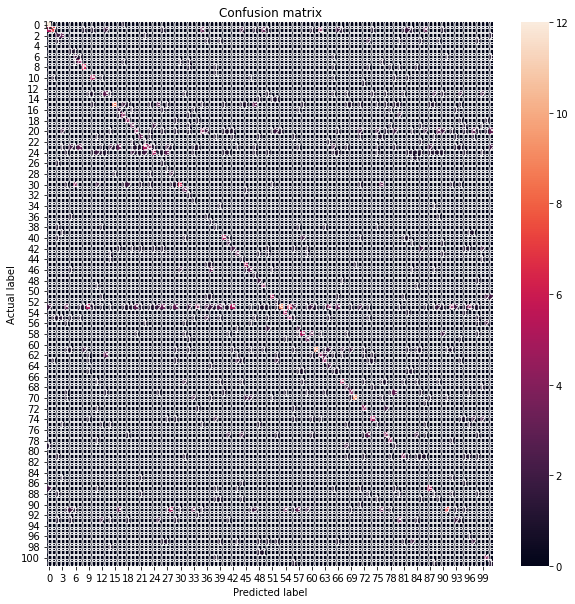

Watching the future...
              precision    recall  f1-score   support

           0       0.53      0.31      0.39        29
           1       0.16      0.75      0.26        40
           2       0.15      0.13      0.14        67
           3       0.06      0.05      0.05        38
           4       0.00      0.00      0.00        28
           5       0.78      0.11      0.19        66
           6       0.25      0.03      0.06        29
           7       0.34      0.39      0.37        28
           8       0.21      0.21      0.21        29
           9       0.00      0.00      0.00        21
          10       0.61      0.38      0.47        65
          11       0.00      0.00      0.00        62
          12       0.00      0.00      0.00        29
          13       0.11      0.33      0.16        36
          14       0.00      0.00      0.00        20
          15       0.07      0.60      0.13        20
          16       0.26      0.23      0.25        39
    

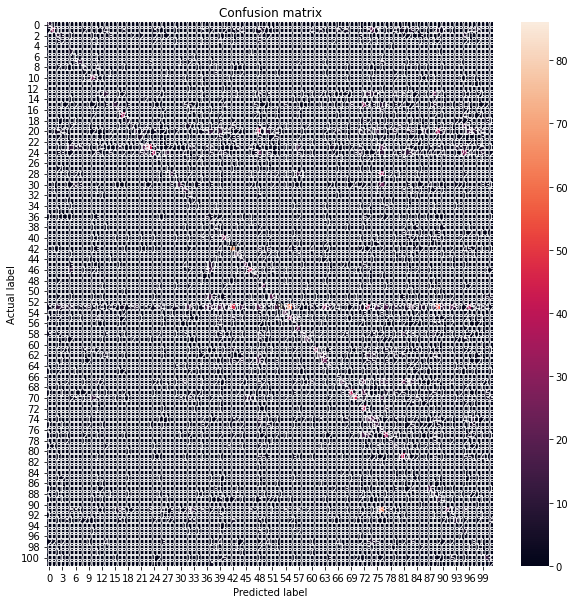

In [ ]:
x_features = np.load(data_path + f'features/x_train_features_{cut}.npy')
x_features_val = np.load(data_path + f'features/x_val_features_{cut}.npy')
x_features_test = np.load(data_path + f'features/x_test_features_{cut}.npy')
y_features = np.load(data_path + f'features/y_train_features_{cut}.npy')
y_features_val = np.load(data_path + f'features/y_val_features_{cut}.npy')
y_features_test = np.load(data_path + f'features/y_test_features_{cut}.npy')

# L2 normalization
x_features = preprocessing.normalize(x_features, axis=1)
x_val_features = preprocessing.normalize(x_features_val, axis=1)
x_test_features = preprocessing.normalize(x_features_test, axis=1)

# Taking the labels
y_features = np.argmax(y_features, axis=1)
y_features_val = np.argmax(y_features_val, axis=1)
y_features_test = np.argmax(y_features_test, axis=1)

svm = LinearSVC()
# Train
print("Training...")
svm.fit(x_features, y_features)

# Eval
print("Evaluating...")
val_predictions = svm.predict(x_val_features)
print(classification_report(y_features_val, val_predictions))
plot_cm(val_predictions, y_features_val)

# Test
print("Watching the future...")
predictions = svm.predict(x_test_features)
print(classification_report(y_features_test, predictions))
plot_cm(predictions, y_features_test)

# Pretrained DenseNet169 as feature extractor (freezed)

In this step, we are freezing the convolutional base of the DenseNet169 and use as a feature extractor for a classifier on top of it and train only the top-level classifier.
Before the fully connected layer we add some normalization to the features extracted.
In this case we are changing only the learning rate, reduced by a factor of 10.



In [ ]:
densenet = tf.keras.applications.densenet.DenseNet169(weights="imagenet", include_top=False,
                                                          input_shape=(224, 224, 3))
densenet.summary()

# Freezing all net (except for the classifier added on top)
densenet.trainable = False

densenet_TF = keras.models.Sequential()
densenet_TF.add(densenet)
densenet_TF.add(layers.GlobalAveragePooling2D())
densenet_TF.add(layers.BatchNormalization())
densenet_TF.add(layers.Dense(102, activation="softmax"))

densenet_TF.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'],
                              loss="categorical_crossentropy")
densenet_TF.summary()

51888128/51877672 [==============================] - 1s 0us/step
Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

### Train/Evaluate/Test

In [ ]:
EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=0.001, restore_best_weights=True,
                                   verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks = [early_stopping, lr_scheduler]

history = densenet_TF.fit(train_generator,
                          epochs=EPOCHS, callbacks=callbacks, 
                          validation_data=validation_generator
                          )

score = densenet_TF.evaluate(validation_generator)
print(f"Val Loss: {score[0]}")
print(f"Val Accuracy: {score[1]}")

Epoch 1/50
127/127 [==============================] - 47s 287ms/step - loss: 4.6993 - accuracy: 0.0119 - val_loss: 4.6284 - val_accuracy: 0.0098 - lr: 1.0000e-04
Epoch 2/50
127/127 [==============================] - 32s 256ms/step - loss: 4.4816 - accuracy: 0.0395 - val_loss: 4.5494 - val_accuracy: 0.0285 - lr: 1.0000e-04
Epoch 3/50
127/127 [==============================] - 32s 255ms/step - loss: 4.3495 - accuracy: 0.0623 - val_loss: 4.4479 - val_accuracy: 0.0541 - lr: 1.0000e-04
Epoch 4/50
127/127 [==============================] - 33s 257ms/step - loss: 4.2179 - accuracy: 0.0949 - val_loss: 4.3228 - val_accuracy: 0.0640 - lr: 1.0000e-04
Epoch 5/50
127/127 [==============================] - 32s 255ms/step - loss: 4.0963 - accuracy: 0.1028 - val_loss: 4.1960 - val_accuracy: 0.0817 - lr: 1.0000e-04
Epoch 6/50
127/127 [==============================] - 33s 257ms/step - loss: 3.9815 - accuracy: 0.1275 - val_loss: 4.0945 - val_accuracy: 0.0955 - lr: 1.0000e-04
Epoch 7/50
127/127 [========

In [ ]:
print(f"Train accuracy: {np.max(history.history['accuracy'])}")
print(f"Validation accuracy: {np.max(history.history['val_accuracy'])}")
print(f"Train loss: {np.max(history.history['loss'])}")
print(f"Validation loss: {np.max(history.history['val_loss'])}")

Train accuracy: 0.6422924995422363
Validation accuracy: 0.3051181137561798
Train loss: 4.699321746826172
Validation loss: 4.628438472747803


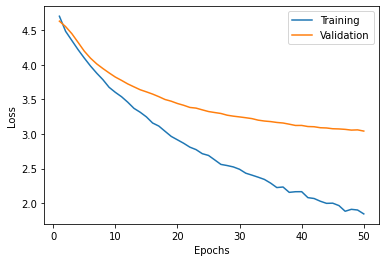

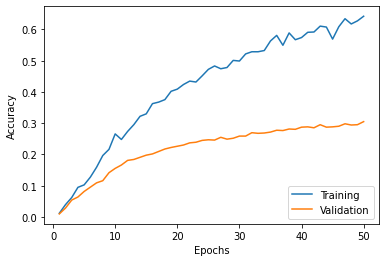

769/769 [==============================] - 67s 87ms/step - loss: 3.2611 - accuracy: 0.2823
Test Loss: 3.261126756668091
Test Accuracy: 0.28232231736183167


In [ ]:
x_plot = list(range(1, len(history.history['val_accuracy']) + 1))
plot_history(history, x_plot)
densenet_TF.save("fine_tuned_densenet_allFreezed")

score = densenet_TF.evaluate(test_generator)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

# Finetuning a pretrained DenseNet169
Now we fine-tune the model by train the weights of the top layers of the pre-trained model alongside the training of the classifier added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the new dataset.

In [ ]:
densenet_FT = tf.keras.applications.densenet.DenseNet169(weights="imagenet", include_top=False,
                                                          input_shape=(224, 224, 3))
densenet_FT.summary()

# Freezing all net except for the last dense block
densenet_FT.trainable = True
for layer in densenet_FT.layers:
    if 'conv5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

fine_tuned_densenet = keras.models.Sequential()
fine_tuned_densenet.add(densenet_FT)
fine_tuned_densenet.add(layers.GlobalAveragePooling2D())
fine_tuned_densenet.add(layers.BatchNormalization())
fine_tuned_densenet.add(layers.Dense(102, activation="softmax"))

fine_tuned_densenet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'],
                              loss="categorical_crossentropy")
fine_tuned_densenet.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_4[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                       

### Train/Evaluate/Test

In [ ]:
EPOCHS = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=0.001, restore_best_weights=True,
                                   verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
callbacks = [early_stopping, lr_scheduler]

history = fine_tuned_densenet.fit(train_generator,
                                  epochs=EPOCHS, callbacks=callbacks, 
                                  validation_data=validation_generator
                                  )

score = fine_tuned_densenet.evaluate(validation_generator)
print(f"Val Loss: {score[0]}")
print(f"Val Accuracy: {score[1]}")

Epoch 1/50
127/127 [==============================] - 55s 335ms/step - loss: 4.5086 - accuracy: 0.0573 - val_loss: 4.4779 - val_accuracy: 0.0374 - lr: 1.0000e-04
Epoch 2/50
127/127 [==============================] - 43s 338ms/step - loss: 3.5372 - accuracy: 0.2085 - val_loss: 3.9572 - val_accuracy: 0.1289 - lr: 1.0000e-04
Epoch 3/50
127/127 [==============================] - 37s 292ms/step - loss: 2.9058 - accuracy: 0.3538 - val_loss: 3.5945 - val_accuracy: 0.1762 - lr: 1.0000e-04
Epoch 4/50
127/127 [==============================] - 33s 261ms/step - loss: 2.4581 - accuracy: 0.4605 - val_loss: 3.4272 - val_accuracy: 0.2175 - lr: 1.0000e-04
Epoch 5/50
127/127 [==============================] - 34s 268ms/step - loss: 2.0903 - accuracy: 0.5385 - val_loss: 3.0516 - val_accuracy: 0.2815 - lr: 1.0000e-04
Epoch 6/50
127/127 [==============================] - 33s 260ms/step - loss: 1.7642 - accuracy: 0.6403 - val_loss: 3.0630 - val_accuracy: 0.2884 - lr: 1.0000e-04
Epoch 7/50
127/127 [========

In [ ]:
print(f"Train accuracy: {np.max(history.history['accuracy'])}")
print(f"Validation accuracy: {np.max(history.history['val_accuracy'])}")
print(f"Train loss: {np.max(history.history['loss'])}")
print(f"Validation loss: {np.max(history.history['val_loss'])}")

Train accuracy: 1.0
Validation accuracy: 0.437992125749588
Train loss: 4.5085768699646
Validation loss: 4.477908134460449


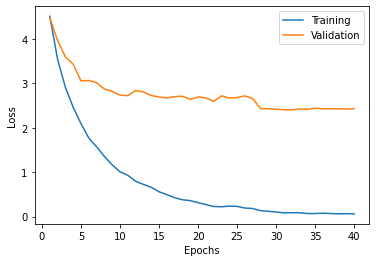

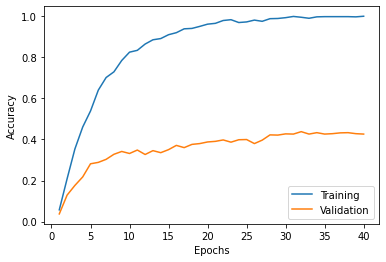

769/769 [==============================] - 59s 77ms/step - loss: 2.7176 - accuracy: 0.4038
Test Loss: 2.7175753116607666
Test Accuracy: 0.4038054943084717


In [ ]:
x_plot = list(range(1, len(history.history['val_accuracy']) + 1))
plot_history(history, x_plot)

score = fine_tuned_densenet.evaluate(test_generator)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")

In [ ]:
fine_tuned_densenet.save(data_path + "fine_tuned_densenet_NOFreezed")


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Flowers/flowers/fine_tuned_densenet_allFreezed/assets
